# Code and additional analysis for Case Study 1

For explanation, please see the full paper.

Install latex for proper math rendering in figures.

In [56]:
!sudo apt install cm-super dvipng texlive-latex-extra texlive-latex-recommended

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
cm-super is already the newest version (0.3.4-17).
dvipng is already the newest version (1.15-1.1).
texlive-latex-extra is already the newest version (2021.20220204-1).
texlive-latex-recommended is already the newest version (2021.20220204-1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [57]:
import numpy as np
import jax.numpy as jnp
import jax
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import scipy.stats
import sympy
import os

plt.rcParams['text.usetex'] = True

plt.style.use("bmh")

In [58]:
fertilizer_applied = jnp.arange(0, 289, 48, dtype=float)
grain_yield = jnp.array([1.5, 3.4, 5.5, 6.8, 6.8, 7.5, 7])   # data from Glendining et al. (1996) (see full paper for deftails)

In [59]:
def saturation(x, a, b, d):
    return a * jnp.exp(-b * x) + d

# use automatic differentiation from jax
grad_saturation = jax.grad(saturation, argnums=0)  # Gradient w.r.t. x (argnums=0)
grad_saturation = jax.vmap(grad_saturation, in_axes=(0, None, None, None))

popt, pcov = curve_fit(saturation, fertilizer_applied, grain_yield, p0=[-5, 0.01, 7], method="dogbox")

In [60]:
a, b, d = popt
c_f = 1.50               # foodsecurityportal2022
c_g = 36.7437 * 5.50     # foodsecurityportal2020 (and conversion from bushel to tonne)

In [61]:
c_g

202.09034999999997

In [62]:
a, b, d

(-6.379655069374017, 0.010739995759392442, 7.701446388417814)

In [63]:
get_fertilizer_prices = lambda x: c_f * x
get_grain_prices = lambda x, a, b, d: c_g * saturation(x, a, b, d)
get_profit = lambda x, a, b, d: get_grain_prices(x, a, b, d) - get_fertilizer_prices(x)

In [64]:
fertilizer_range = jnp.arange(0, 300, 1, dtype=float)
grain_yield_range = saturation(fertilizer_range, *popt)
delta_grain_yield_range = grad_saturation(fertilizer_range, *popt)

fertilizer_prices = get_fertilizer_prices(fertilizer_range)
grain_prices = get_grain_prices(fertilizer_range, *popt)

profit = get_profit(fertilizer_range, *popt)

delta_fertilizer_prices = jax.vmap(jax.grad(get_fertilizer_prices))(fertilizer_range)
delta_grain_prices = jax.vmap(jax.grad(get_grain_prices, argnums=0), in_axes=(0, None, None, None))(fertilizer_range, *popt)

In [65]:
x_max = (delta_grain_prices > delta_fertilizer_prices).sum().item()

In [66]:
def get_x_max_sigma(sigma, a, b, d):
    return (b**2 * sigma**2 - 2 * jnp.log(-c_f / (a * b * c_g))) / (2 * b)

Compare numeric and symbolic calculation of x_max:

In [67]:
x_max_symbolic = -(1/b)*jnp.log(-c_f/c_g*1/(a*b))
print(x_max)
print(x_max_symbolic)

207
206.94453


In [68]:
sigma = 50

In [69]:
probability_density = scipy.stats.norm.pdf(fertilizer_range, get_x_max_sigma(sigma, a, b, d), sigma)

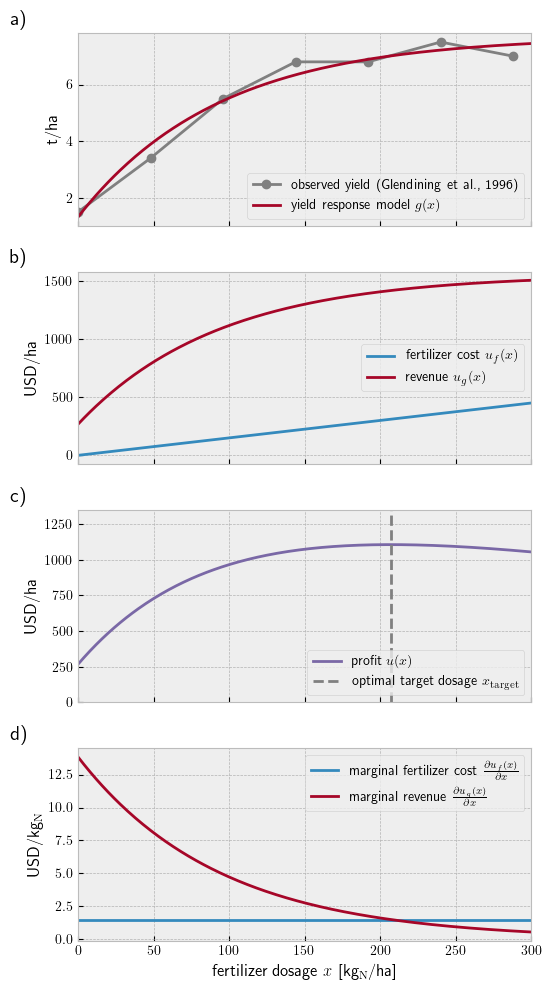

In [70]:
fig, axs = plt.subplots(4, figsize=(5.5, 10), sharex=True)
ax = axs[0]
ax.plot(fertilizer_applied, grain_yield, c="gray", marker="o", label="observed yield (Glendining et al., 1996)")

ax.plot(fertilizer_range, grain_yield_range, c="C1", label="yield response model $g(x)$")
ax.set_ylabel('t/ha')
ax.legend()

ax.set_title("a)", loc="left", x=-0.15)

axs[1].plot(fertilizer_range, fertilizer_prices, label="fertilizer cost $u_f(x)$")
axs[1].plot(fertilizer_range, grain_prices, label="revenue $u_g(x)$")
axs[1].set_ylabel('USD/ha')
axs[1].legend()
axs[1].set_title("b)", loc="left", x=-0.15)

axs[2].plot(fertilizer_range, profit, label="profit $u(x)$", c="C2")
axs[2].vlines(x_max_symbolic, 0, 13.5e2, color="gray", linestyle="dashed", label=r"optimal target dosage $x_\mathrm{target}$", zorder=2)
axs[2].set_ylabel('USD/ha')
axs[2].legend()
axs[2].set_ylim(0, 13.5e2)
axs[2].set_title("c)", loc="left", x=-0.15)

axs[3].plot(fertilizer_range, delta_fertilizer_prices, label=r"marginal fertilizer cost $\frac{\partial u_f(x)}{\partial x}$")
axs[3].plot(fertilizer_range, delta_grain_prices, label=r"marginal revenue $\frac{\partial u_g(x)}{\partial x}$")
axs[3].set_ylabel('USD/kg$_\mathrm{N}$')
axs[3].legend()
axs[3].set_title("d)", loc="left", x=-0.15)

axs[3].set_xlabel('fertilizer dosage $x$ [kg$_\mathrm{N}$/ha]')




axs[3].set_xlim(0, 300)
fig.tight_layout()

fig.savefig("synplot1.png", dpi=600)
fig.savefig("synplot1.svg")

In [71]:
def expected_profit(a, b, d, sigma, x_max):
    term1 = c_g * a * jnp.exp(0.5 * (b**2) * (sigma**2)) * np.exp(-b * x_max)
    term2 = c_g * d
    term3 = -c_f * x_max
    return term1 + term2 + term3

Expected value of perfect precision as a function of standard deviation.

Text(0, 0.5, 'EVPP')

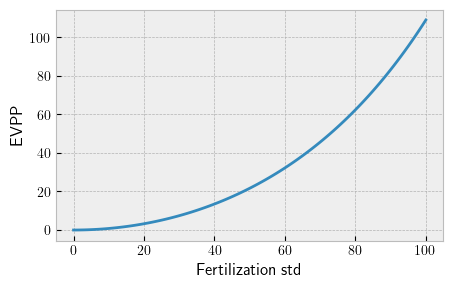

In [72]:
std_range = jnp.linspace(0, 100, 100)
std_profit = expected_profit(a, b, d, std_range, x_max_symbolic)

fig, ax = plt.subplots(figsize=(5, 3))
ax.plot(std_range, expected_profit(a, b, d, 0, x_max_symbolic) -std_profit)
ax.set_xlabel("Fertilization std")
ax.set_ylabel("EVPP")

In [73]:
print(expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d)))
print(expected_profit(a, b, d, sigma, x_max_symbolic))

1086.169
1084.6448


In [74]:
EVPP = expected_profit(a, b, d, 0, x_max_symbolic) - expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d))
EVPP

Array(20.137451, dtype=float32)

In [75]:
key = jax.random.key(0)
random_samples = jnp.clip(jax.random.normal(key, (50000,)) * sigma + get_x_max_sigma(sigma, a, b, d), 0)

get_profit(random_samples, a, b, d).mean()

Array(1086.2144, dtype=float32)

In [76]:
get_profit(random_samples, a, b, d).mean() / expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d))

Array(1.0000418, dtype=float32)

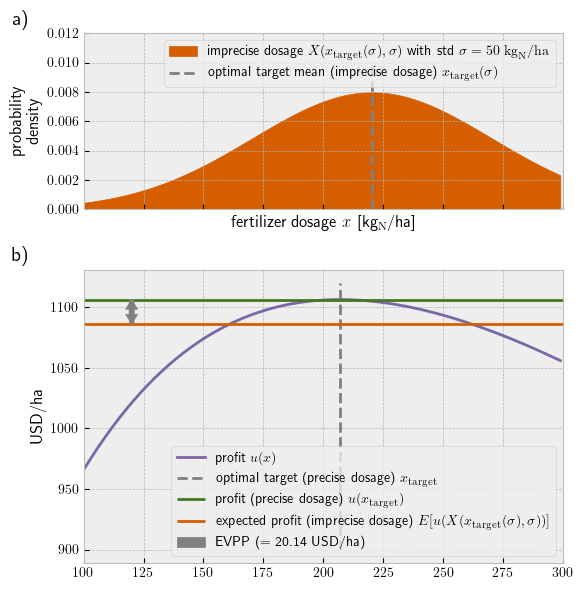

In [77]:
fig, axs = plt.subplots(2, 1, figsize=(6, 6), sharex=True, height_ratios=[3, 5])

axt = axs[0]
ax = axs[1]

mask = slice(100, None)

axt.fill_between(fertilizer_range[mask], 0, probability_density[mask], color="C4", label="imprecise dosage $X(x_\mathrm{target}(\sigma), \sigma)$ with std $\sigma = 50  \ \mathrm{kg}_\mathrm{N} / \mathrm{ha}$", alpha=1)

axt.vlines(get_x_max_sigma(sigma, a, b, d), 0, 0.01, color="gray", linestyle="dashed", label="optimal target mean (imprecise dosage) $x_\mathrm{target}(\sigma)$", zorder=2)

axt.set_ylabel('probability\ndensity')
axt.set_ylim(0, 0.012)
axt.legend()
axt.set_title("a)", loc="left", x=-0.15)


ax.plot(fertilizer_range[mask], profit[mask], label="profit $u(x)$", c="C2")
ax.vlines(x_max_symbolic, 9e2, 11.2e2, color="gray", linestyle="dashed", label=r"optimal target (precise dosage) $x_\mathrm{target}$", zorder=2)
ax.hlines(expected_profit(a, b, d, 0, x_max_symbolic), 0, 300, color="C3", label=r"profit (precise dosage) $u(x_\mathrm{target})$", zorder=2)
ax.hlines(expected_profit(a, b, d, 50, get_x_max_sigma(sigma, a, b, d)), 0, 300, color="C4", label=r"expected profit (imprecise dosage) $E[u(X(x_\mathrm{target}(\sigma), \sigma))]$", zorder=2)


ax.arrow(120, expected_profit(a, b, d, 50, get_x_max_sigma(sigma, a, b, d)),
         0, EVPP, width=2, head_width=5, head_length=8, fc='gray', ec='gray',
         length_includes_head=True, zorder=5, label="EVPP (= {:.2f} USD/ha)".format(EVPP))

ax.arrow(120, expected_profit(a, b, d, 0, x_max_symbolic),
         0, -EVPP, width=2, head_width=5, head_length=8, fc='gray', ec='gray',
         length_includes_head=True, zorder=5)



ax.legend()
ax.set_ylabel('USD/ha')
ax.set_title("b)", loc="left", x=-0.15)

#ax.set_ylim(9e4, 11.5e2)

axt.set_xlabel('fertilizer dosage $x$ [kg$_\mathrm{N}$/ha]')

axt.set_xlim(100, 300)
fig.tight_layout()

fig.savefig("synplot2.png", dpi=600)
fig.savefig("synplot2.svg")

In [78]:
def EVPP_fun(a, b, d, x_max, sigma):
    return expected_profit(a, b, d, 0, x_max) - expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d))

def EVPP_fun_analytic(a, b, d, x_max, sigma):
    return (c_g * (a * jnp.exp(-b * (-1/b) * jnp.log(-c_f / (c_g * a * b))) + d) \
         - c_f * (-1/b) * jnp.log(-c_f / (c_g * a * b)) \
         - (- c_g * a * jnp.exp(b**2 * sigma**2 / 2) * jnp.exp(-b * (b**2 * sigma**2 - 2 * jnp.log(-c_f / (c_g * a * b))) / (2 * b)) \
         + c_g * d - (c_f / (2 * b)) * (b**2 * sigma**2 - 2 * jnp.log(-c_f / (c_g * a * b)))))

def EVPP_fun_reduced(a, b, d, x_max, sigma):
    return (b**2 * c_f * sigma**2 - 4 * c_f) / (2 * b)

In [79]:
EVPP_fun(a, b, d, x_max_symbolic, sigma)

Array(20.137451, dtype=float32)

In [80]:
EVPP_fun_reduced(a, b, d, x_max_symbolic, sigma)

-259.1922271809081

In [81]:
EVPP_fun_analytic(a, b, d, x_max_symbolic, sigma)

Array(-259.19214, dtype=float32)

In [82]:
print(x_max_symbolic)
print((-1/b * jnp.log(-c_f / (c_g * a * b))))

206.94453
206.94453


In [83]:
print(expected_profit(a, b, d, 0, x_max_symbolic))
print(expected_profit(a, b, d, sigma, get_x_max_sigma(sigma, a, b, d)))

1106.3064
1086.169


Test symbolic solution (from Maxima)

In [84]:
print((a * jnp.exp(-b * (-1/b * jnp.log(-c_f / (c_g * a * b)))) + d) * c_g - c_f * (-1/b * jnp.log(-c_f / (c_g * a * b))).item())
print(c_g * a * jnp.exp((b**2 * sigma**2) / 2) * jnp.exp(-b * ((b**2 * sigma**2 - 2 * jnp.log(-c_f / (a * b * c_g))) / (2 * b))) + c_g * d - c_f * ((b**2 * sigma**2 - 2 * jnp.log(-c_f / (a * b * c_g))) / (2 * b)))

1106.3064
1086.169


In [85]:
print(((b**2 * sigma**2 - 2 * jnp.log(-c_f / (a * b * c_g))) / (2 * b)))
print(get_x_max_sigma(sigma, a, b, d))

220.3695
220.3695


Symbolically simplify solution using sympy.

In [86]:
c_g, a, b, c_f, sigma, d = sympy.symbols('c_g a b c_f sigma d')
symbolic_e_u_0 = (a * sympy.exp(-b * (-1/b * sympy.log(-c_f / (c_g * a * b)))) + d) * c_g - c_f * (-1/b * sympy.log(-c_f / (c_g * a * b)))
symbolic_e_u_sigma = c_g * a * sympy.exp((b**2 * sigma**2) / 2) * sympy.exp(-b * ((b**2 * sigma**2 - 2 * sympy.log(-c_f / (a * b * c_g))) / (2 * b))) + c_g * d - c_f * ((b**2 * sigma**2 - 2 * sympy.log(-c_f / (a * b * c_g))) / (2 * b))
sympy.simplify(symbolic_e_u_0 - symbolic_e_u_sigma)

b*c_f*sigma**2/2

Create Latex math code to include in the paper.

In [87]:
sympy.latex(sympy.simplify(symbolic_e_u_0 - symbolic_e_u_sigma))

'\\frac{b c_{f} \\sigma^{2}}{2}'

In [88]:
a, b, d = popt
c_f = 1.50               # foodsecurityportal2022
c_g = 36.7437 * 5.50     # foodsecurityportal2020 (and conversion from bushel to tonne)
sigma = 50

0.5 * b * c_f * sigma**2

20.137492048860828

In [89]:
with sympy.evaluate(False):
    print(symbolic_e_u_0)

c_g*(d - c_f/(b*c_g)) + c_f*log(-c_f/(a*b*c_g))/b
